# Imports

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import hvplot.pandas
import holoviews as hv
%config InlineBackend.figure_format='retina'

# Load the data (don't forget to export a csv once its clean)

In [3]:
columns = ['State', 'Year', 'Product Name', 'Number of Prescriptions']
filenames = ['State_Drug_Utilization_Data_' + str(i) + '.csv' for i in range(1991, 2019)]

df = pd.concat(pd.read_csv(filename, usecols=columns)
               for filename in filenames)

In [7]:
df.shape

(82413509, 4)

In [11]:
df.head()

,State,Year,Product Name,Number of Prescriptions
0,MA,1991,Dicyclomin,29.0
1,AR,1991,NaN,NaN
2,CT,1991,GUAIFED-PD,124.0
3,TN,1991,LOMOTIL,NaN
4,TX,1991,DYMELOR 25,NaN


# Optimize memory usage

In [5]:
# Perform real memory usage calculation at the cost of computational resources

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82413509 entries, 0 to 2365964
Data columns (total 4 columns):
State                      object
Year                       int64
Product Name               object
Number of Prescriptions    float64
dtypes: float64(1), int64(1), object(2)
memory usage: 11.5 GB


In [14]:
# Average memory usage by datatype

for dtype in ['float','int','object']:
    selected_dtype = df.select_dtypes(include=[dtype])
    mean_usage_b = selected_dtype.memory_usage(deep=True).mean()
    mean_usage_mb = mean_usage_b / 1024 ** 2
    print("Average memory usage for {} columns: {:03.2f} MB".format(dtype,mean_usage_mb))

Average memory usage for float columns: 628.77 MB
Average memory usage for int columns: 628.77 MB
Average memory usage for object columns: 3497.44 MB


In [23]:
# Function to optimize integer columns with subtypes

# use .select_dtypes to select integer columns
# downcast to the best integer subtype using .to_numeric()

def mem_usage(pandas_obj):
    if isinstance(pandas_obj,pd.DataFrame):
        usage_b = pandas_obj.memory_usage(deep=True).sum()
    else: # we assume if not a df it's a series
        usage_b = pandas_obj.memory_usage(deep=True)
    usage_mb = usage_b / 1024 ** 2 # convert bytes to megabytes
    return "{:03.2f} MB".format(usage_mb)

df_int = df.select_dtypes(include=['int'])
converted_int = df_int.apply(pd.to_numeric,downcast='unsigned')

print('Original:', mem_usage(df_int))
print('Converted:', mem_usage(converted_int))

compare_ints = pd.concat([df_int.dtypes,converted_int.dtypes],axis=1)
compare_ints.columns = ['before','after']
compare_ints.apply(pd.Series.value_counts)

Original: 1257.53 MB
Converted: 785.96 MB


,before,after
uint16,NaN,1.0
int64,1.0,NaN


The improvement in memory from downcasting is amazing already, let's keep doing it.

In [24]:
# Optimize float columns with the function

df_float = df.select_dtypes(include=['float'])
converted_float = df_float.apply(pd.to_numeric,downcast='float')

print(mem_usage(df_float))
print(mem_usage(converted_float))

compare_floats = pd.concat([df_float.dtypes,converted_float.dtypes],axis=1)
compare_floats.columns = ['before','after']
compare_floats.apply(pd.Series.value_counts)

1257.53 MB
943.15 MB


,before,after
float32,NaN,1.0
float64,1.0,NaN


Converting object to category type typically saves huge amounts of memory, for this to work propery, the data should have have cardinality of no more than 50%.

In [33]:
# Let's reload the dataset with the best possible dtypes

# State and Product Name are our object columns
# unique values in those columns definitely comprise < 50% of the data
# float32 for number of prescriptions
# uint16 for year 
# category for state and product name

columns = ['State', 'Year', 'Product Name', 'Number of Prescriptions']
filenames = ['State_Drug_Utilization_Data_' + str(i) + '.csv' for i in range(1991, 2019)]

df = pd.concat(pd.read_csv(filename, usecols=columns, 
               dtype={'Year':'uint16','Number of Prescriptions':'float32'})
               for filename in filenames)

# For some reason category conversion doesn't work from read_csv
# so we'll do it separate 

df[['State', 'Product Name']] = df[['State', 'Product Name']].astype('category')

In [11]:
# Check memory usage now

df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
Int64Index: 82413509 entries, 0 to 2365964
Data columns (total 4 columns):
State                      category
Year                       uint16
Product Name               category
Number of Prescriptions    float32
dtypes: category(2), float32(1), uint16(1)
memory usage: 1.5 GB


**The amount of memory saved by converting to category is insane.**

# Clean the data

In [15]:
df.isna().sum()

State                             0
Year                              0
Product Name                 379049
Number of Prescriptions    41161540
dtype: int64

In [47]:
len(df[df['Product Name'] == '?'])

6938

In [49]:
(df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions']).isna().sum()

12132

In [50]:
# Replace ? with nan

df = df.replace('?', np.NaN)

# Drop the nans

df = df.dropna(subset=['Product Name'])

# Remove aggregated XX entries

df = df[df.State != 'XX']

# Nullify and impute SD Precriptions in 2007

df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions'] = np.nan

# Randomly sample values from comparable North Dakota
# to fill Nans in South Dakota 2007

samp = df.loc[(df['Year'] <= 2008) & (df['State'] == 'ND'), 'Number of Prescriptions'].sample(12132)
df.loc[(df['Year'] == 2007) & (df['State'] == 'SD'), 'Number of Prescriptions'] = samp.values

In [51]:
# Check missing values

df.isna().sum()

State                             0
Year                              0
Product Name                      0
Number of Prescriptions    39634733
dtype: int64

In [31]:
# Export the cleaned version so I don't have to load the whole thing everytime

df.to_csv('Medicaid_data_1991_2017.csv')

In [52]:
# Pearson correlation for all entries including non-numeric

df.apply(lambda x: x.factorize()[0]).corr()

,State,Year,Product Name,Number of Prescriptions
State,1.000000,0.012710,-0.002349,-0.041835
Year,0.012710,1.000000,0.474652,0.010433
Product Name,-0.002349,0.474652,1.000000,0.004970
Number of Prescriptions,-0.041835,0.010433,0.004970,1.000000


# Stacked Barchart of # prescriptions

In [34]:
df.info(memory_usage='deep')

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77020970 entries, 0 to 77020969
Data columns (total 5 columns):
Unnamed: 0                 int64
State                      category
Year                       int64
Product Name               category
Number of Prescriptions    float64
dtypes: category(2), float64(1), int64(2)
memory usage: 2.1 GB


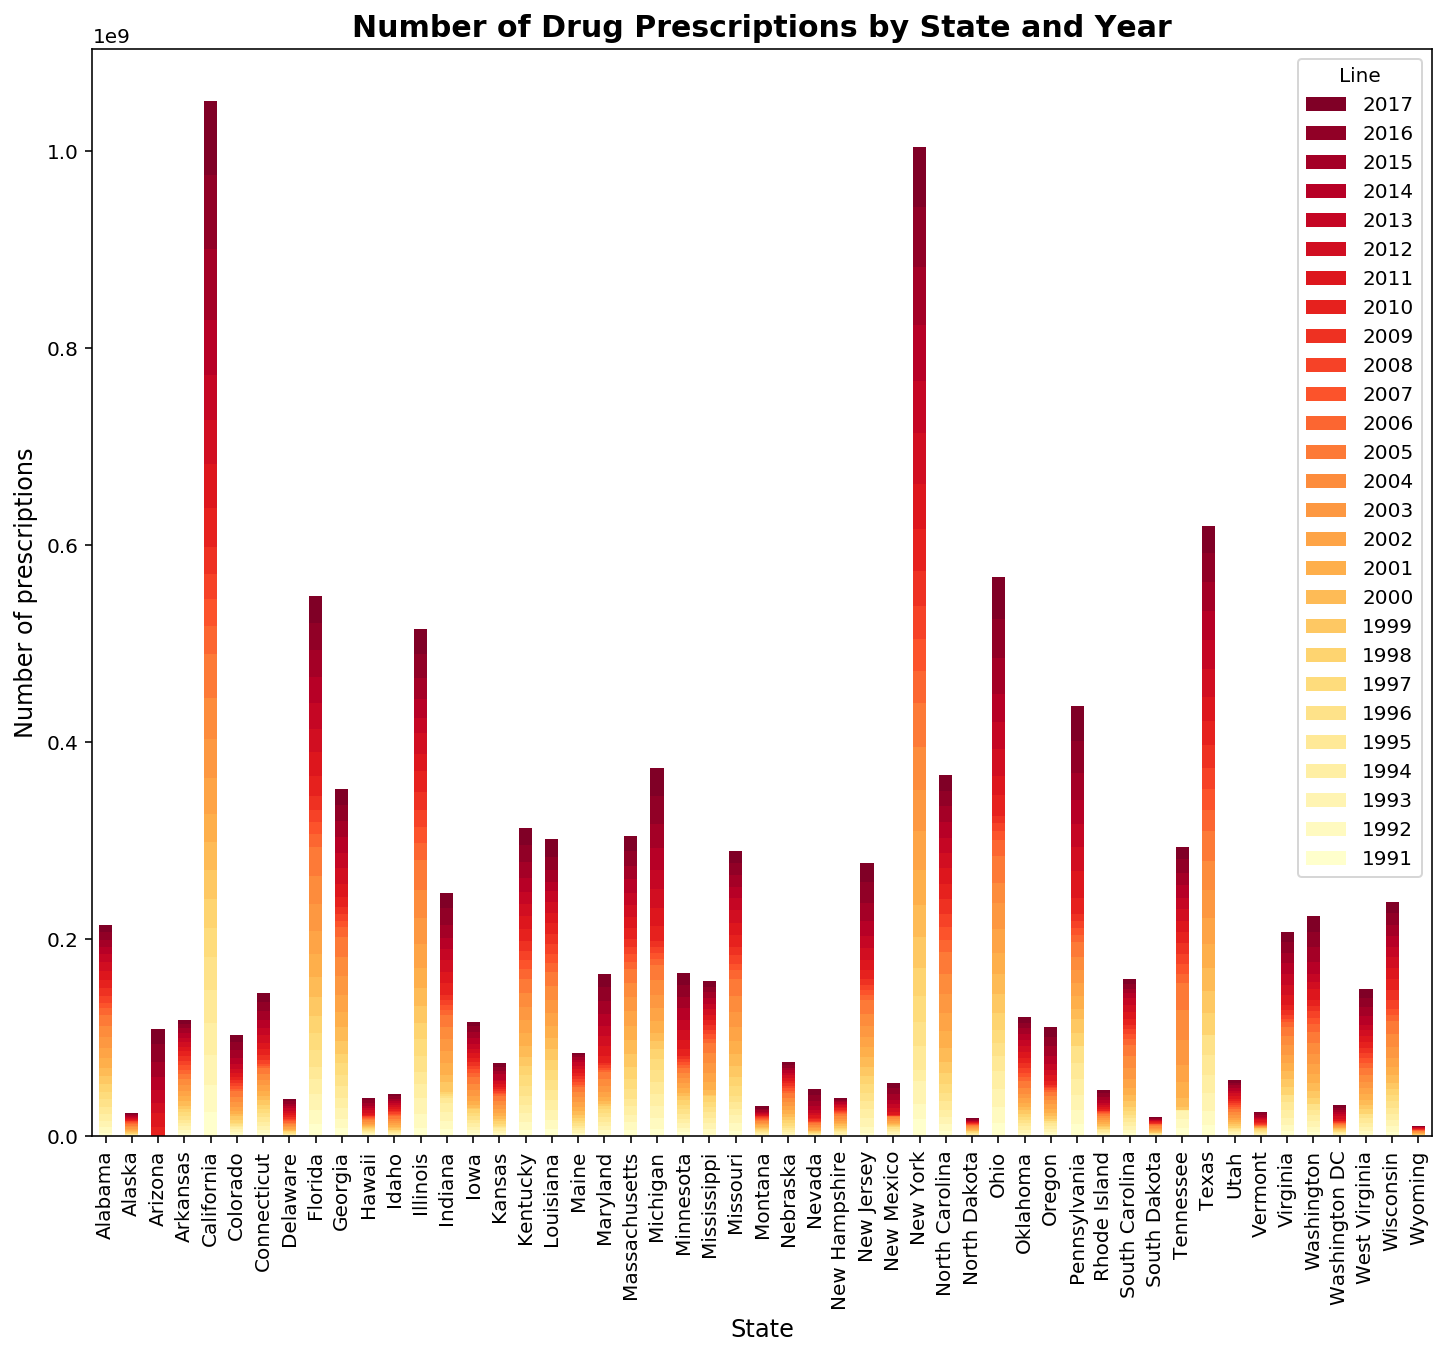

In [199]:
pv = df.pivot_table(values='Number of Prescriptions', index='State', columns='Year', aggfunc=np.sum)

# Number of prescriptions by state 2007 - 2017

ax = pv.sort_values('State').plot.bar(stacked=True, figsize=(12,10), cmap='YlOrRd')
ax.set_title('Number of Drug Prescriptions by State and Year', size=15, weight='bold')
plt.ylabel('Number of prescriptions', size=12)
plt.xlabel('State', size=12)

# Reverse the legend labels and handles for better readability

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Line', loc='best');

In [143]:
df.shape

(77020970, 4)

In [8]:
len(df.loc[df['Number of Prescriptions'] > 20000, 'Number of Prescriptions'])

46512

In [10]:
# Nan the rows where Number of prescriptions > 20000

df.loc[df['Number of Prescriptions'] > 20000, 'Number of Prescriptions'] = np.nan

In [35]:
df.isna().sum()

Unnamed: 0                        0
State                             0
Year                              0
Product Name                      0
Number of Prescriptions    39681245
dtype: int64

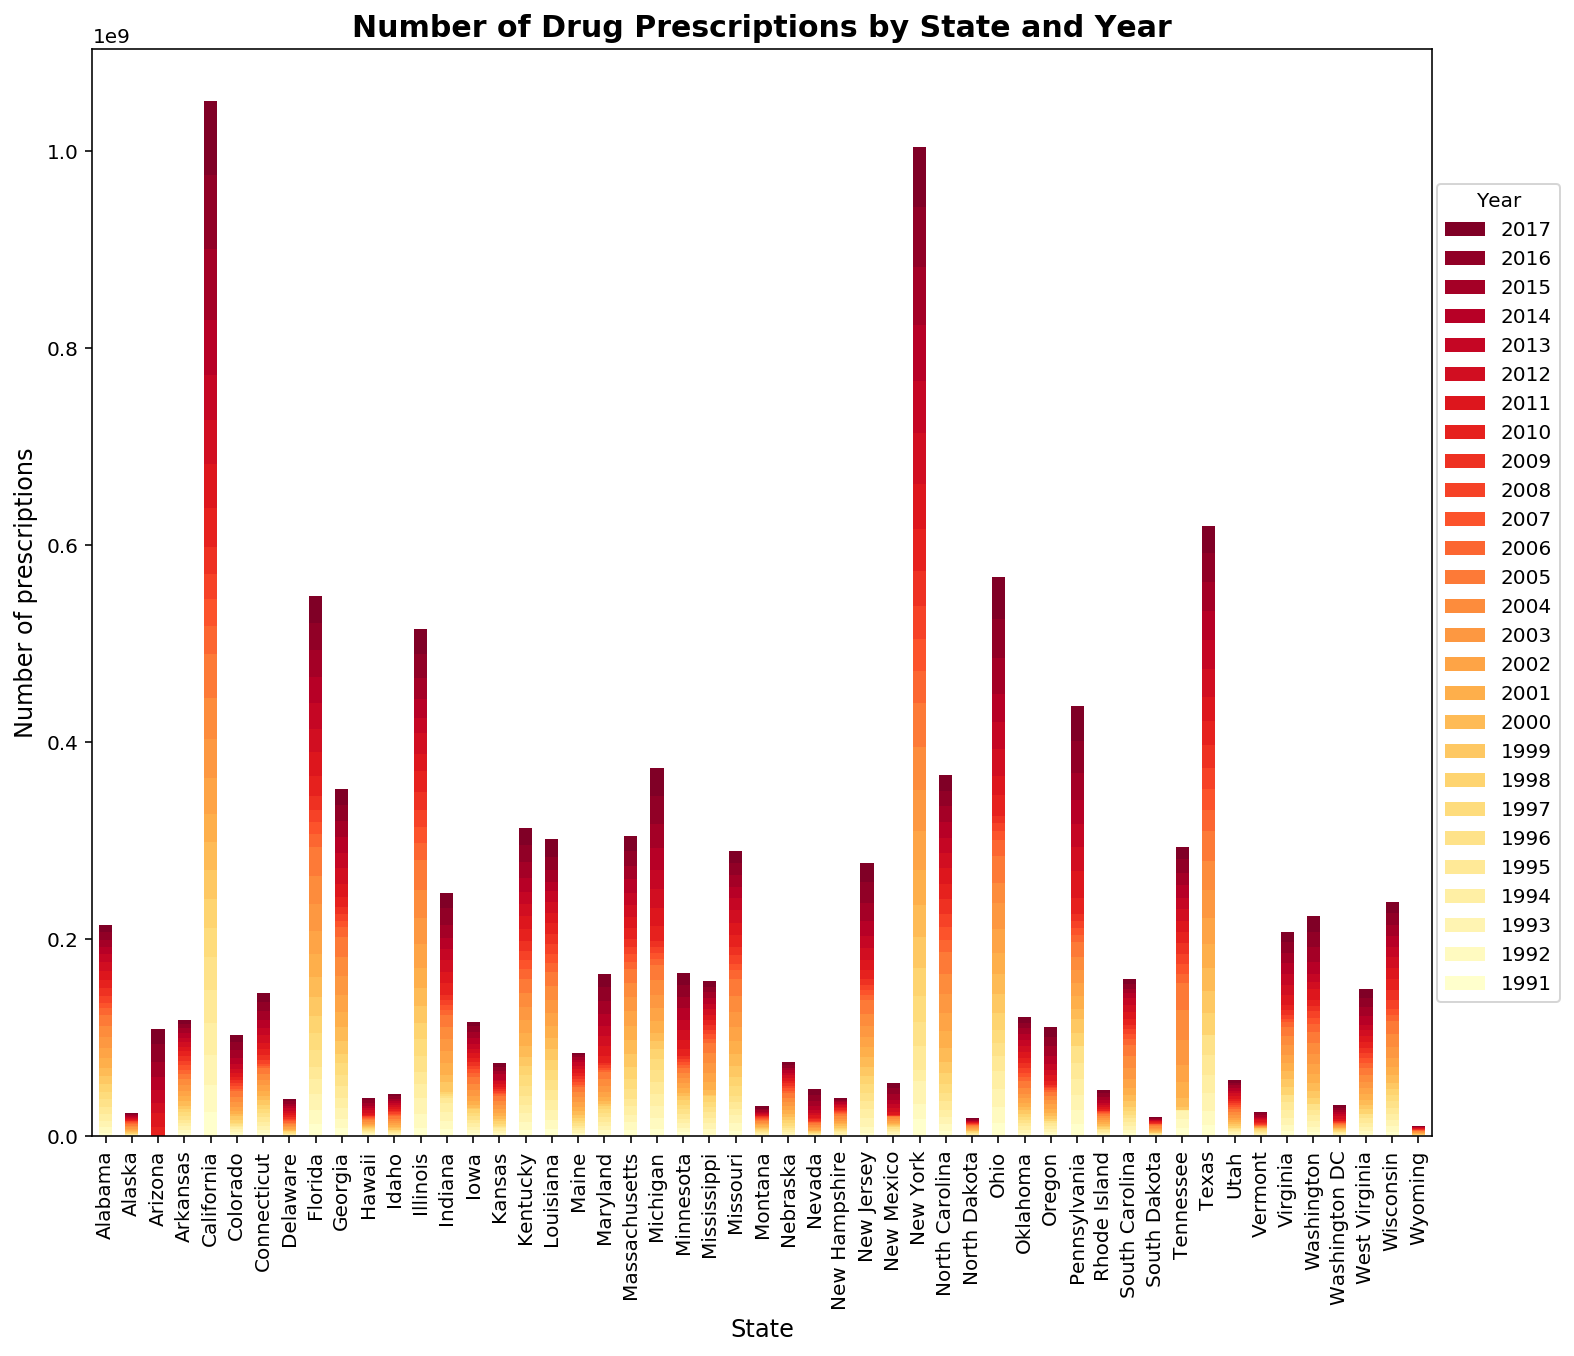

In [201]:
## Again without the outliers
pv = df.pivot_table(values='Number of Prescriptions', index='State', columns='Year', aggfunc=np.sum)

# Number of prescriptions by state 2007 - 2017

ax = pv.sort_values('State').plot.bar(stacked=True, figsize=(12,10), cmap='YlOrRd')
ax.set_title('Number of Drug Prescriptions by State and Year', size=15, weight='bold')
plt.ylabel('Number of prescriptions', size=12)
plt.xlabel('State', size=12)

# Reverse the legend labels and handles for better readability

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Year', loc='center', bbox_to_anchor=(1.05, 0.5));

Populations:

* Texas 28.3 million
* Florida 21 million
* Illinois 12.8 million
* Ohio 11.6 million

# Heatmap visulization

In [148]:
# Make abbreviated state into full

abb = {
    'Alabama': 'AL',
    'Alaska': 'AK',
    'Arizona': 'AZ',
    'Arkansas': 'AR',
    'California': 'CA',
    'Colorado': 'CO',
    'Connecticut': 'CT',
    'Delaware': 'DE',
    'Florida': 'FL',
    'Georgia': 'GA',
    'Hawaii': 'HI',
    'Idaho': 'ID',
    'Illinois': 'IL',
    'Indiana': 'IN',
    'Iowa': 'IA',
    'Kansas': 'KS',
    'Kentucky': 'KY',
    'Louisiana': 'LA',
    'Maine': 'ME',
    'Maryland': 'MD',
    'Massachusetts': 'MA',
    'Michigan': 'MI',
    'Minnesota': 'MN',
    'Mississippi': 'MS',
    'Missouri': 'MO',
    'Montana': 'MT',
    'Nebraska': 'NE',
    'Nevada': 'NV',
    'New Hampshire': 'NH',
    'New Jersey': 'NJ',
    'New Mexico': 'NM',
    'New York': 'NY',
    'North Carolina': 'NC',
    'North Dakota': 'ND',
    'Ohio': 'OH',
    'Oklahoma': 'OK',
    'Oregon': 'OR',
    'Pennsylvania': 'PA',
    'Rhode Island': 'RI',
    'South Carolina': 'SC',
    'South Dakota': 'SD',
    'Tennessee': 'TN',
    'Texas': 'TX',
    'Utah': 'UT',
    'Vermont': 'VT',
    'Virginia': 'VA',
    'Washington': 'WA',
    'Washington DC': 'DC',
    'West Virginia': 'WV',
    'Wisconsin': 'WI',
    'Wyoming': 'WY',
}

abb = {state: abbrev for abbrev, state in abb.items()}
df['State'] = df['State'].map(abb)
# df_pop['State'] = df_pop['State'].map(abb)

In [207]:
# Get the top 100 most prescribed drugs in the nation
# 109 because we drop some of the ones with missing entries

top100 = df.groupby('Product Name')['Number of Prescriptions'].agg('sum').sort_values(ascending=False).head(110)

# get names of drugs into a variable

t100 = top100.index.values
top100.head(10)

Product Name
HYDROCODON    178082416.0
AMOXICILLI    176532568.0
FUROSEMIDE    134708807.0
LISINOPRIL    118654156.0
IBUPROFEN     108590698.0
ALBUTEROL     105458215.0
ALPRAZOLAM     96897572.0
ACETAMINOP     86892391.0
CLONAZEPAM     85178646.0
LORAZEPAM      83742949.0
Name: Number of Prescriptions, dtype: float64

In [190]:
# Make new df of top 100 drugs

df100 = pd.concat(df.loc[df['Product Name'] == drug] for drug in t100)
# df100 = df100.sort_values('State')
df100.head()

,State,Year,Product Name,Number of Prescriptions,Number of People On Medicaid,Prescriptions Per Ppl Medicaid,Population,Presciptions Per Capita
310,Massachusetts,1991,HYDROCODON,NaN,1581381,NaN,6018470,NaN
590,Massachusetts,1991,HYDROCODON,57.0,1581381,0.000036,6018470,0.000009
2039,Massachusetts,1991,HYDROCODON,NaN,1581381,NaN,6018470,NaN
2416,Massachusetts,1991,HYDROCODON,NaN,1581381,NaN,6018470,NaN
3233,Massachusetts,1991,HYDROCODON,NaN,1581381,NaN,6018470,NaN


In [191]:
# Make Total Number of Prescriptions for easy plotting

df100['Total Number of Prescriptions'] = df100.groupby(['Product Name', 'State'])['Number of Prescriptions'].transform(sum)
df100 = df100.sort_values('State')

# Prescription Rates of Top 100 Drugs 1991 - 2018

In [202]:
df100.Year.unique()

array([1997, 2007, 1992, 2013, 1995, 2015, 2014, 1996, 2016, 2006, 1998,
       2005, 2008, 1994, 1993, 2017, 2001, 2004, 2012, 2011, 2002, 1999,
       2000, 2003, 1991, 2009, 2010])

In [193]:
# imports for visualization

import hvplot.pandas
import holoviews as hv

In [203]:
# Heatmap by state and year

heatmap = df100.hvplot.heatmap('Product Name', 'State', 'Total Number of Prescriptions',
          height=500, width=1000, xaxis=None, hover_cols=['Year'], flip_yaxis=True,
          title='Top 100 Most Prescribed Drugs in the Nation in 1991 - 2017', cmap='fire')
heatmap

:HeatMap   [Product Name,State]   (Total Number of Prescriptions,Year)

In [195]:
# Drop these drugs for a better heatmap

drop_these_drugs = ['PREMARIN T', 'ASPIRIN EC', 'AMOXIL(AMO',
                    'OXYCODONE-', 'DOCUSATE S', 'ADVAIR DIS',
                    'LANOXIN TA', 'FERROUS SU']

for i in drop_these_drugs:
    df100.drop(df100.loc[df100['Product Name'] == i].index, inplace=True)

# See prescriptions by state

In [73]:
# Get rid of 2018 since there's only data for 1/2 the year

no2018_df = df[df['Year'] != 2018]

p_agg = no2018_df.groupby(['Year', 'State'])['Number of Prescriptions'].sum()
by_state = p_agg.hvplot('Year', groupby='State', width=500, dynamic=False)
by_state

by_state = macro.to(hv.Curve, 'year', 'unem', groupby='country')
print(curves)
curves

:HoloMap   [State]
   :Curve   [Year]   (Number of Prescriptions)

# Visualize prescriptions per number of Medicaid enrolees

In [149]:
# Number of people on Medicaid by state

numppl = {    
    'Alabama': 895557,
    'Alaska': 211386,
    'Arizona': 1701640,
    'Arkansas': 867135,
    'California': 11848844,
    'Colorado': 1315090,
    'Connecticut': 329960,
    'Delaware': 248489,
    'Florida': 2491106,
    'Georgia': 1771598,
    'Hawaii': 331537,
    'Idaho': 279162,
    'Illinois': 2859467,
    'Indiana': 1443601,
    'Iowa': 331506,
    'Kansas': 389662,
    'Kentucky': 1222239,
    'Louisiana': 1482264,
    'Maine': 260969,
    'Maryland': 1302294,
    'Massachusetts': 1581381,
    'Michigan': 2309439,
    'Minnesota': 1050064,
    'Mississippi': 632877,
    'Missouri': 895063,
    'Montana': 276352,
    'Nebraska': 243159,
    'Nevada': 639840,
    'New Hampshire': 180354,
    'New Jersey': 1712130,
    'New Mexico': 727516,
    'New York': 6514626,
    'North Carolina': 2042755,
    'North Dakota': 91378,
    'Ohio': 2679329,
    'Oklahoma': 779128,
    'Oregon': 967235,
    'Pennsylvania': 2934869,
    'Rhode Island': 308678,
    'South Carolina': 1020780,
    'South Dakota': 116366,
    'Tennessee': 1381351,
    'Texas': 4305085,
    'Utah': 288484,
    'Vermont': 158298,
    'Virginia': 1036625,
    'Washington': 1734705,
    'Washington DC': 259430,
    'West Virginia': 535206,
    'Wisconsin': 1018153,
    'Wyoming': 57372
}

# Make a new column with number of people

df['Number of People On Medicaid'] = df['State'].map(numppl)

In [150]:
df['Prescriptions Per Capita'] = df['Number of Prescriptions'] / df['Number of People On Medicaid']

In [81]:
df.head()

,State,Year,Product Name,Number of Prescriptions,Number of People On Medicaid,Prescriptions Per Capita
0,Massachusetts,1991,Dicyclomin,29.0,1581381,0.000018
1,Connecticut,1991,GUAIFED-PD,124.0,329960,0.000376
2,Tennessee,1991,LOMOTIL,NaN,1381351,NaN
3,Texas,1991,DYMELOR 25,NaN,4305085,NaN
4,Illinois,1991,Betamethas,23.0,2859467,0.000008


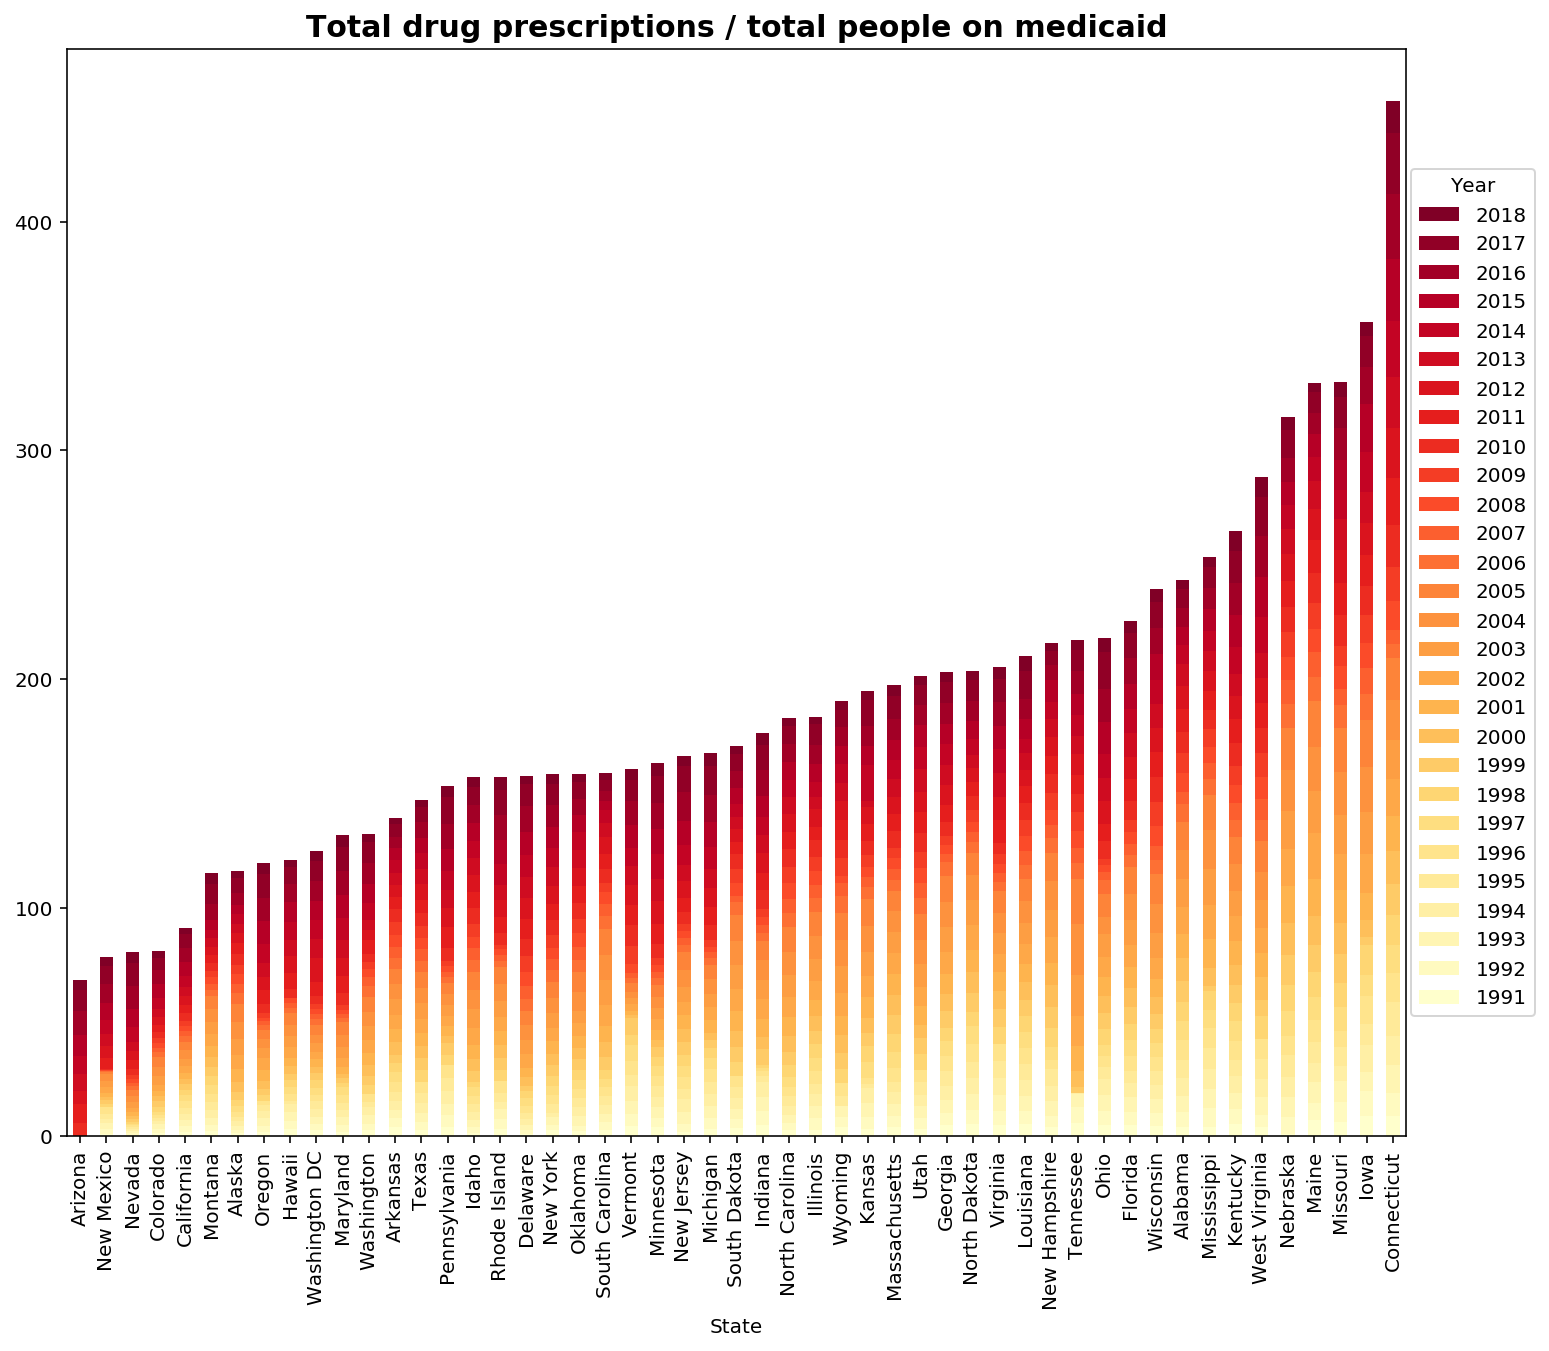

In [166]:
# Visualize prescriptions per medicaid population

pv = df.pivot_table(values='Prescriptions Per Capita', index='State', 
                    columns='Year', aggfunc=np.sum, margins=True)
pv = pv.sort_values('All')

ax = pv.loc[pv.index != 'All', pv.columns != 'All'].plot.bar(stacked=True, figsize=(12,10), cmap='YlOrRd')
ax.set_title('Total drug prescriptions / total people on medicaid', size=15, weight='bold')

# Reverse the legend labels and handles for better readability

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Year', loc='center', 
          bbox_to_anchor=(1.05, 0.5));

# Visualize the number of prescriptions per capita
Let's use census population data instead and map it to every year to get numbers per capita.

In [139]:
df = pd.read_csv('Medicaid_data_1991_2017.csv')

In [164]:
df = df.merge(df_census)
df['Presciptions Per Capita'] = df['Number of Prescriptions'] / df['Population']

In [183]:
df[df['State'] == 'Arizona']['Presciptions Per Capita'].sum()

16.267089893136255

In [117]:
# I need population by state and year

df_pop['Year'] = df_pop[1].str.slice(0,4)
df_pop['State'] = df_pop[1].str.slice(4,6)
df_pop['Population'] = df_pop[1].str.slice(18, 26)
df_census = pd.read_csv('US_CENSUS_DATA_CLEAN_1969_2017.csv')
df_census = df_pop[df_pop['Year'] > 1990]

In [159]:
df_census.head()

,State,Year,Population
0,Alabama,1991,4099156
1,Alabama,1992,4154014
2,Alabama,1993,4214202
3,Alabama,1994,4260229
4,Alabama,1995,4296800


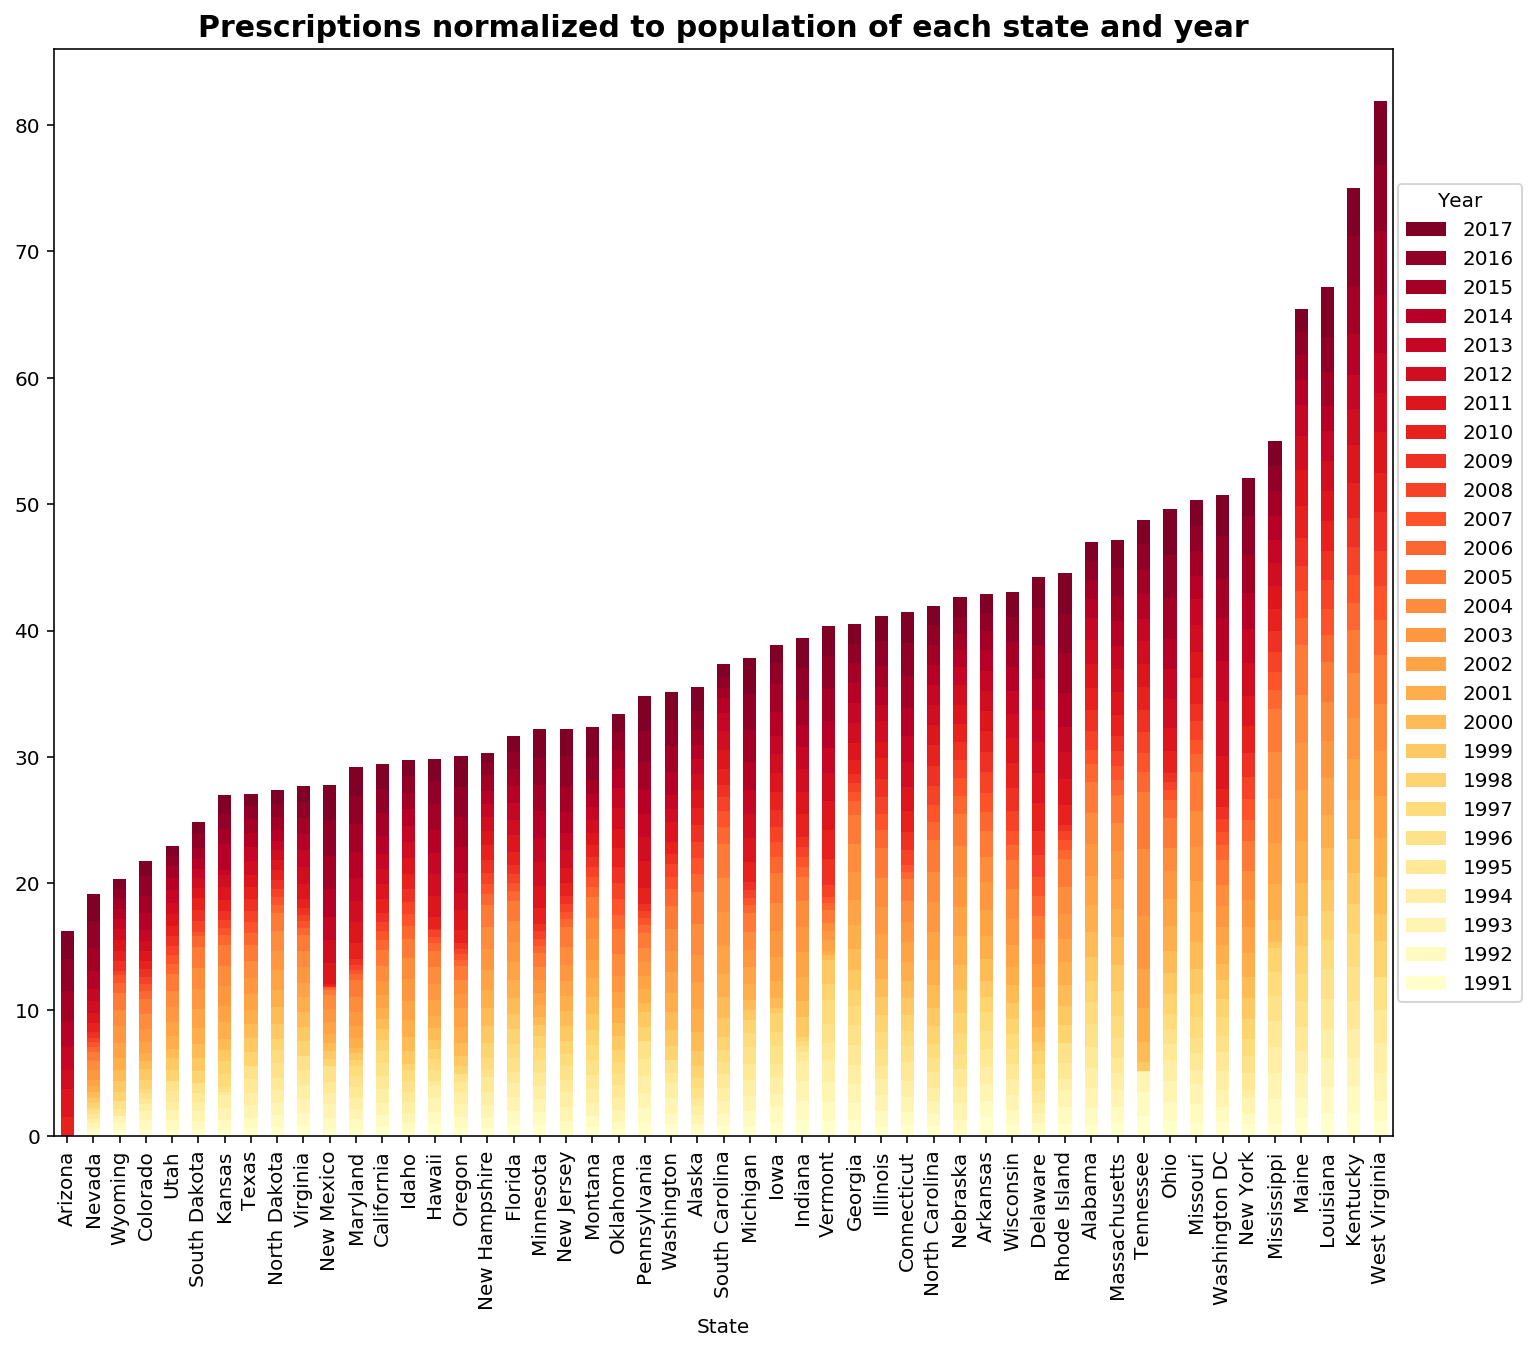

In [200]:
## Visualize prescritions per capita

pv = df.pivot_table(values='Presciptions Per Capita', index='State', 
                    columns='Year', aggfunc=np.sum, margins=True)
pv = pv.sort_values('All')

ax = pv.loc[pv.index != 'All', pv.columns != 'All'].plot.bar(stacked=True, figsize=(12,10), cmap='YlOrRd')
ax.set_title('Prescriptions normalized to population of each state and year', size=15, weight='bold')

# Reverse the legend labels and handles for better readability

handles, labels = ax.get_legend_handles_labels()
ax.legend(reversed(handles), reversed(labels), title='Year', loc='center', 
          bbox_to_anchor=(1.05, 0.5));

In [185]:
df.corr()

,Year,Number of Prescriptions,Number of People On Medicaid,Prescriptions Per Ppl Medicaid,Population,Presciptions Per Capita
Year,1.000000,0.015346,0.043073,0.008307,0.107953,-0.003852
Number of Prescriptions,0.015346,1.000000,0.149663,0.605433,0.152274,0.646489
Number of People On Medicaid,0.043073,0.149663,1.000000,-0.107663,0.942125,-0.087559
Prescriptions Per Ppl Medicaid,0.008307,0.605433,-0.107663,1.000000,-0.114698,0.928230
Population,0.107953,0.152274,0.942125,-0.114698,1.000000,-0.108548
Presciptions Per Capita,-0.003852,0.646489,-0.087559,0.928230,-0.108548,1.000000


In [186]:
df.apply(lambda x: x.factorize()[0]).corr()

,State,Year,Product Name,Number of Prescriptions,Number of People On Medicaid,Prescriptions Per Ppl Medicaid,Population,Presciptions Per Capita
State,1.000000,0.012669,-0.001084,-0.047242,1.000000,0.271368,0.015344,-0.037757
Year,0.012669,1.000000,0.492468,0.011010,0.012669,0.038211,0.999326,0.430039
Product Name,-0.001084,0.492468,1.000000,0.003491,-0.001084,0.002458,0.492394,0.177022
Number of Prescriptions,-0.047242,0.011010,0.003491,1.000000,-0.047242,0.505135,0.009934,0.205814
Number of People On Medicaid,1.000000,0.012669,-0.001084,-0.047242,1.000000,0.271368,0.015344,-0.037757
Prescriptions Per Ppl Medicaid,0.271368,0.038211,0.002458,0.505135,0.271368,1.000000,0.037431,0.505528
Population,0.015344,0.999326,0.492394,0.009934,0.015344,0.037431,1.000000,0.429576
Presciptions Per Capita,-0.037757,0.430039,0.177022,0.205814,-0.037757,0.505528,0.429576,1.000000
